In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import concatenate
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import imageio
import matplotlib.pyplot as plt
%matplotlib inline

path = ''
image_path = os.path.join(path, '/content/drive/MyDrive/DL_CV/archive/CameraRGB/')
mask_path = os.path.join(path, '/content/drive/MyDrive/DL_CV/archive/CameraMask/')
# List and sort the filenames
image_list = sorted(os.listdir(image_path), key=lambda x: int(x.split('.')[0]))
mask_list = sorted(os.listdir(mask_path), key=lambda x: int(x.split('.')[0]))
# Add the full paths
image_list = [os.path.join(image_path, i) for i in image_list]
mask_list = [os.path.join(mask_path, i) for i in mask_list]

In [ ]:
import tensorflow as tf

# List available physical GPUs
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print("GPU is available!")
    for gpu in gpus:
        print(" -", gpu)
else:
    print("No GPU detected.")

!nvidia-smi # temp is 43c 166MiB /  15360MiB memory used

GPU is available!
 - PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
Sat Feb  8 05:44:29 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   46C    P8             12W /   70W |       2MiB /  15360MiB |      0%      Default |
|                                         |           

In [ ]:
len(image_list)

960

In [ ]:
len(mask_list)

960

In [ ]:
image_list[-1]

'/content/drive/MyDrive/DL_CV/archive/CameraRGB/064421.png'

In [ ]:
mask_list[-1]

'/content/drive/MyDrive/DL_CV/archive/CameraMask/064421.png'

<ipython-input-35-cd49dac50305>:2: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(image_list[N])
<ipython-input-35-cd49dac50305>:3: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  mask = imageio.imread(mask_list[N])


Text(0.5, 1.0, 'Segmentation')

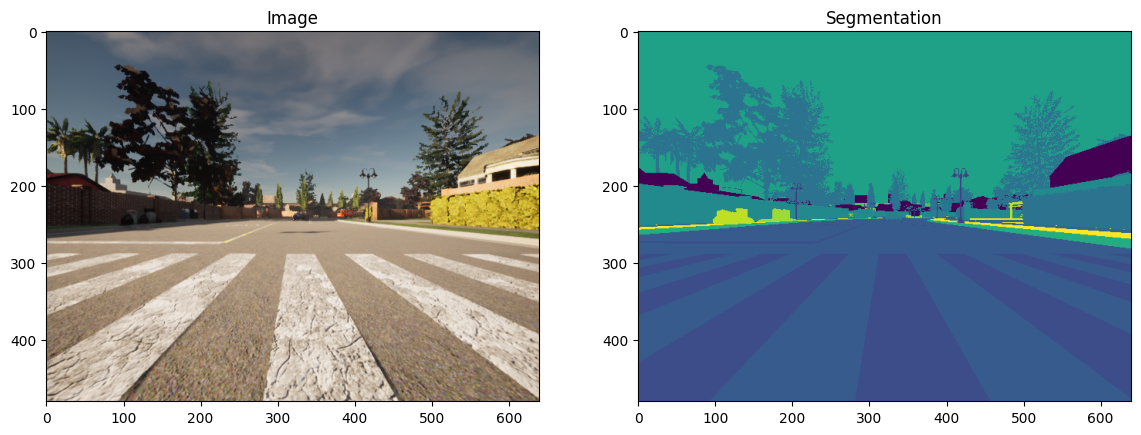

In [ ]:
N = 859
img = imageio.imread(image_list[N])
mask = imageio.imread(mask_list[N])
#mask = np.array([max(mask[i, j]) for i in range(mask.shape[0]) for j in range(mask.shape[1])]).reshape(img.shape[0], img.shape[1])

fig, arr = plt.subplots(1, 2, figsize=(14, 10))
arr[0].imshow(img)
arr[0].set_title('Image')
arr[1].imshow(mask[:, :, 0])
arr[1].set_title('Segmentation')

In [ ]:
image_list_ds = tf.data.Dataset.list_files(image_list, shuffle=False)
mask_list_ds = tf.data.Dataset.list_files(mask_list, shuffle=False)

for path in zip(image_list_ds.take(3), mask_list_ds.take(3)):
    print(path)

(<tf.Tensor: shape=(), dtype=string, numpy=b'/content/drive/MyDrive/DL_CV/archive/CameraRGB/002294.png'>, <tf.Tensor: shape=(), dtype=string, numpy=b'/content/drive/MyDrive/DL_CV/archive/CameraMask/002294.png'>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'/content/drive/MyDrive/DL_CV/archive/CameraRGB/002295.png'>, <tf.Tensor: shape=(), dtype=string, numpy=b'/content/drive/MyDrive/DL_CV/archive/CameraMask/002295.png'>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'/content/drive/MyDrive/DL_CV/archive/CameraRGB/002296.png'>, <tf.Tensor: shape=(), dtype=string, numpy=b'/content/drive/MyDrive/DL_CV/archive/CameraMask/002296.png'>)


In [ ]:
image_filenames = tf.constant(image_list)
masks_filenames = tf.constant(mask_list)

dataset = tf.data.Dataset.from_tensor_slices((image_filenames, masks_filenames))

for image, mask in dataset.take(2):
    print(image)
    print(mask)

tf.Tensor(b'/content/drive/MyDrive/DL_CV/archive/CameraRGB/002294.png', shape=(), dtype=string)
tf.Tensor(b'/content/drive/MyDrive/DL_CV/archive/CameraMask/002294.png', shape=(), dtype=string)
tf.Tensor(b'/content/drive/MyDrive/DL_CV/archive/CameraRGB/002295.png', shape=(), dtype=string)
tf.Tensor(b'/content/drive/MyDrive/DL_CV/archive/CameraMask/002295.png', shape=(), dtype=string)


In [ ]:
def process_path(image_path, mask_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)

    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=3)
    mask = tf.math.reduce_max(mask, axis=-1, keepdims=True)
    return img, mask

def preprocess(image, mask):
    input_image = tf.image.resize(image, (96, 128), method='nearest')
    input_mask = tf.image.resize(mask, (96, 128), method='nearest')

    input_image = input_image / 255.

    return input_image, input_mask

image_ds = dataset.map(process_path)
processed_image_ds = image_ds.map(preprocess)

In [ ]:
# UNQ_C1
def conv_block(inputs=None, n_filters=32, dropout_prob=0, max_pooling=True):
    """
    Convolutional downsampling block

    Arguments:
        inputs -- Input tensor
        n_filters -- Number of filters for the convolutional layers
        dropout_prob -- Dropout probability
        max_pooling -- Use MaxPooling2D to reduce the spatial dimensions of the output volume
    Returns:
        next_layer, skip_connection --  Next layer and skip connection outputs
    """

    conv = Conv2D(n_filters, # Number of filters
                  3,# Kernel size
                  activation='relu',
                  padding='same',
                  kernel_initializer= 'he_normal')(inputs)
    conv = Conv2D(n_filters, # Number of filters
                  3,# Kernel size
                  activation='relu',
                  padding='same',
                  kernel_initializer= 'he_normal')(conv)

    # if dropout_prob > 0 add a dropout layer, with the variable dropout_prob as parameter
    if dropout_prob > 0:
        conv = Dropout(dropout_prob)(conv)


    # if max_pooling is True add a MaxPooling2D with 2x2 pool_size
    if max_pooling:
        next_layer = MaxPooling2D(2,strides=2)(conv)

    else:
        next_layer = conv

    skip_connection = conv

    return next_layer, skip_connection

In [ ]:
# UNQ_C2
def upsampling_block(expansive_input, contractive_input, n_filters=32):
    """
    Convolutional upsampling block

    Arguments:
        expansive_input -- Input tensor from previous layer
        contractive_input -- Input tensor from previous skip layer
        n_filters -- Number of filters for the convolutional layers
    Returns:
        conv -- Tensor output
    """

    up = Conv2DTranspose(
                 n_filters,    # number of filters
                 3,# Kernel size
                 strides=2,
                 padding='same')(expansive_input)

    # Merge the previous output and the contractive_input
    merge = concatenate([up, contractive_input], axis=3)

    conv = Conv2D(n_filters, # Number of filters
                  3,# Kernel size
                  activation='relu',
                  padding='same',
                  kernel_initializer= 'he_normal')(merge)
    conv = Conv2D(n_filters, # Number of filters
                  3,# Kernel size
                  activation='relu',
                  padding='same',
                  kernel_initializer= 'he_normal')(conv)

    return conv

In [ ]:
# UNQ_C3
def unet_model(input_size=(96, 128, 3), n_filters=32, n_classes=23):
    """
    Unet model

    Arguments:
        input_size -- Input shape
        n_filters -- Number of filters for the convolutional layers
        n_classes -- Number of output classes
    Returns:
        model -- tf.keras.Model
    """
    inputs = Input(input_size)
    # Contracting Path (encoding)
    # Add a conv_block with the inputs of the unet_ model and n_filters
    ### START CODE HERE
    cblock1 = conv_block(inputs=inputs, n_filters=n_filters*1)
    # Chain the first element of the output of each block to be the input of the next conv_block.
    # Double the number of filters at each new step
    cblock2 = conv_block(inputs=cblock1[0], n_filters=n_filters*2)
    cblock3 = conv_block(inputs=cblock2[0], n_filters=n_filters*4)
    # Include a dropout of 0.3 for this layer
    cblock4 = conv_block(inputs=cblock3[0], n_filters=n_filters*8,dropout_prob=0.3)
    # Include a dropout of 0.3 for this layer, and avoid the max_pooling layer
    cblock5 = conv_block(inputs=cblock4[0], n_filters=n_filters*16,dropout_prob=0.3, max_pooling=False)

    # Expanding Path (decoding)
    # Add the first upsampling_block.
    # From here,at each step, use half the number of filters of the previous block
    # Use the cblock5[0] as expansive_input and cblock4[1] as contractive_input and n_filters * 8
    ublock6 = upsampling_block(cblock5[0], cblock4[1], n_filters*8)
    # Chain the output of the previous block as expansive_input and the corresponding contractive block output.
    # Note that you must use the second element of the contractive block i.e before the maxpooling layer.

    ublock7 = upsampling_block(ublock6, cblock3[1], n_filters*4)
    ublock8 = upsampling_block(ublock7, cblock2[1], n_filters*2)
    ublock9 = upsampling_block(ublock8, cblock1[1], n_filters*1)

    conv9 = Conv2D(n_filters,
                 3,
                 activation='relu',
                 padding='same',
                 kernel_initializer='he_normal')(ublock9)

    # Add a Conv2D layer with n_classes filter, kernel size of 1 and a 'same' padding
    conv10 = Conv2D(n_classes, 1, padding='same')(conv9)


    model = tf.keras.Model(inputs=inputs, outputs=conv10)

    return model

In [ ]:
img_height = 96
img_width = 128
num_channels = 3

unet = unet_model((img_height, img_width, num_channels))

In [ ]:
unet.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 96, 128, 3)     │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 96, 128, 32)    │            896 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 96, 128, 32)    │          9,248 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 48, 64, 32)     │              0 │ conv2d_1[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 48, 64, 64)     │         18,496 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 48, 64, 64)     │         36,928 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 24, 32, 64)     │              0 │ conv2d_3[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 24, 32, 128)    │         73,856 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 24, 32, 128)    │        147,584 │ conv2d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 12, 16, 128)    │              0 │ conv2d_5[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 12, 16, 256)    │        295,168 │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 12, 16, 256)    │        590,080 │ conv2d_6[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 12, 16, 256)    │              0 │ conv2d_7[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_3           │ (None, 6, 8, 256)      │              0 │ dropout[0][0]          │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_8 (Conv2D)         │ (None, 6, 8, 512)      │      1,180,160 │ max_pooling2d_3[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_9 (Conv2D)         │ (None, 6, 8, 512)      │      2,359,808 │ conv2d_8[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 6, 8, 512)      │              0 │ conv2d_9[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose     

 Total params: 8,640,471 (32.96 MB)

 Trainable params: 8,640,471 (32.96 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
unet.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

(480, 640, 1)


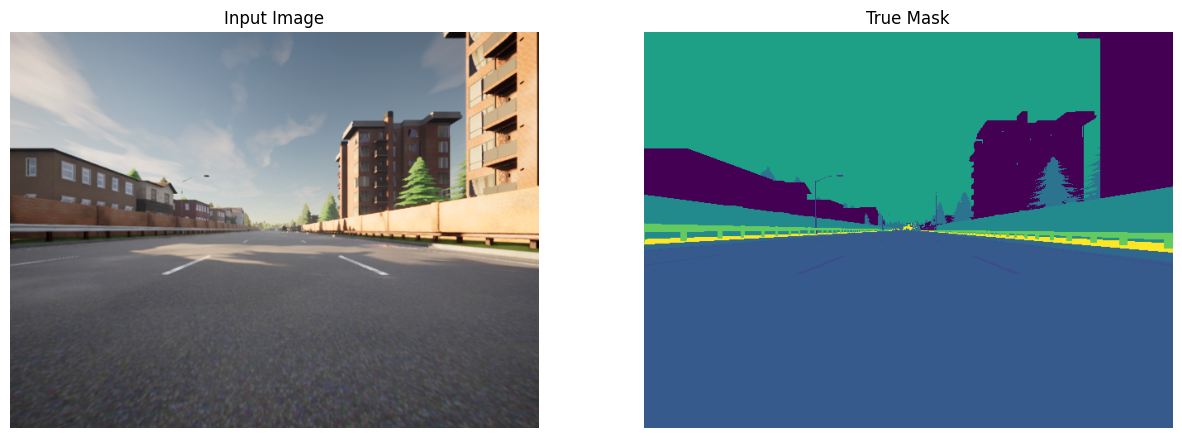

In [ ]:
for image, mask in image_ds.take(1):
    sample_image, sample_mask = image, mask
    print(mask.shape)
display([sample_image, sample_mask])

(96, 128, 1)


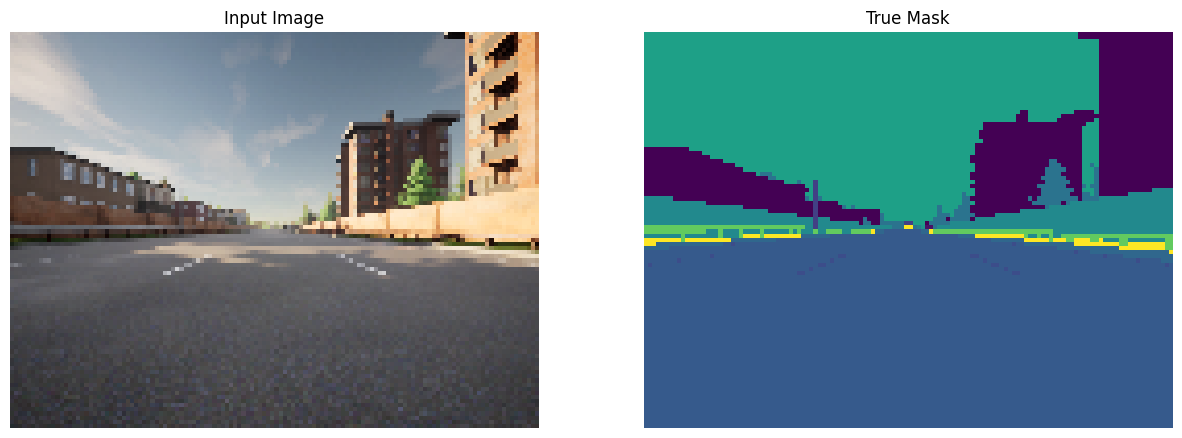

In [ ]:
for image, mask in processed_image_ds.take(1):
    sample_image, sample_mask = image, mask
    print(mask.shape)
display([sample_image, sample_mask])

In [ ]:
EPOCHS = 50
VAL_SUBSPLITS = 5
BUFFER_SIZE = 500
BATCH_SIZE = 32
processed_image_ds.batch(BATCH_SIZE)
train_dataset = processed_image_ds.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
print(processed_image_ds.element_spec)
#model_history = unet.fit(train_dataset, epochs=EPOCHS)
with tf.device('/GPU:0'):
    model_history = unet.fit(train_dataset, epochs=EPOCHS)

(TensorSpec(shape=(96, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(96, 128, 1), dtype=tf.uint8, name=None))
Epoch 1/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 333s 4s/step - accuracy: 0.3239 - loss: 3.1486
Epoch 2/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 60s 133ms/step - accuracy: 0.4808 - loss: 1.6086
Epoch 3/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 133ms/step - accuracy: 0.7483 - loss: 0.9228
Epoch 4/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 132ms/step - accuracy: 0.7657 - loss: 0.7720
Epoch 5/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 133ms/step - accuracy: 0.7786 - loss: 0.7269
Epoch 6/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 135ms/step - accuracy: 0.7878 - loss: 0.7186
Epoch 7/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - accuracy: 0.7958 - loss: 0.6744
Epoch 8/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 135ms/step - accuracy: 0.7998 - loss: 0.6614
Epoch 9/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 136ms/step - accuracy: 0.7945 - loss: 0.6802
Epoch 10/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 135ms/step - accuracy: 0.7926 - loss: 0.6685
Epoch 11/50
30/30 

In [ ]:
!nvidia-smi # temp is 74c, memory used 7800MiB /  15360MiB

Sat Feb  8 05:56:57 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   73C    P0             34W /   70W |    7796MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
unet.save_weights('/content/drive/MyDrive/DL_CV/unet.weights.h5')
unet.save('/content/drive/MyDrive/DL_CV/unet_model.keras')
unet.save('/content/drive/MyDrive/DL_CV/unet_model.h5')

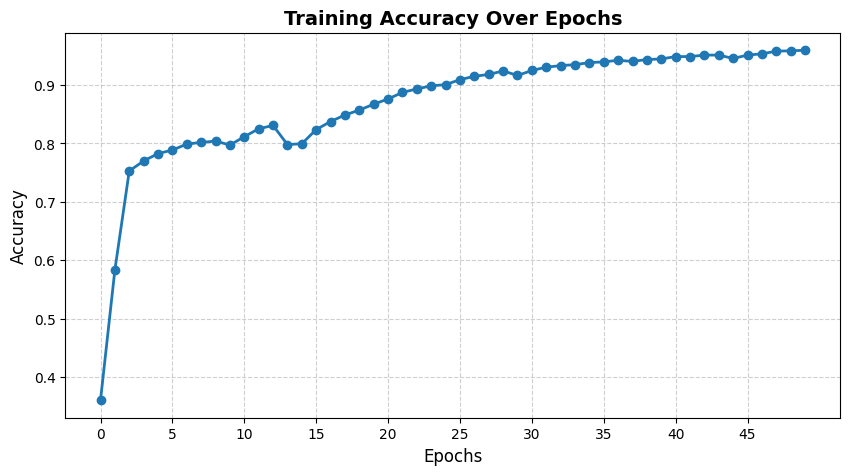

In [ ]:
import matplotlib.pyplot as plt

accuracy = model_history.history["accuracy"]
plt.figure(figsize=(10, 5))
plt.plot(accuracy, marker='o', linestyle='-', linewidth=2, markersize=6)
plt.title("Training Accuracy Over Epochs", fontsize=14, fontweight='bold')
plt.xlabel("Epochs", fontsize=12)
plt.ylabel("Accuracy", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(range(0, len(accuracy), max(1, len(accuracy)//10)))

plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


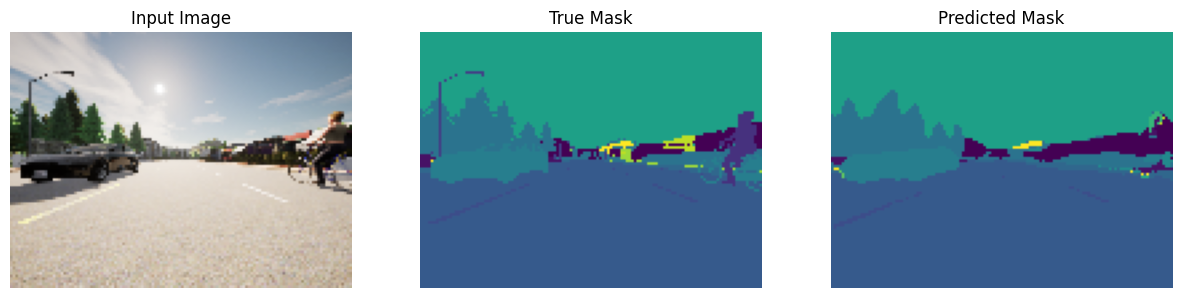

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


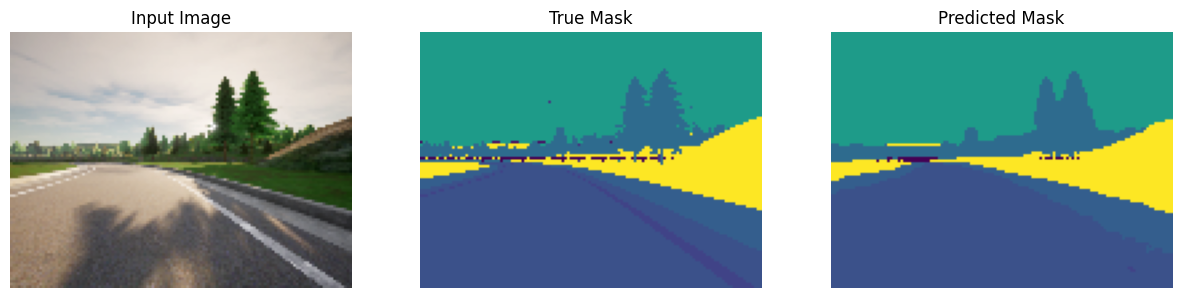

In [ ]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

def show_predictions(dataset=None, num=1):
    """
    Displays the first image of each of the num batches
    """
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = unet.predict(image)
            display([image[0], mask[0], create_mask(pred_mask)])
    else:
        display([sample_image, sample_mask,
             create_mask(unet.predict(sample_image[tf.newaxis, ...]))])

show_predictions(train_dataset, 2)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


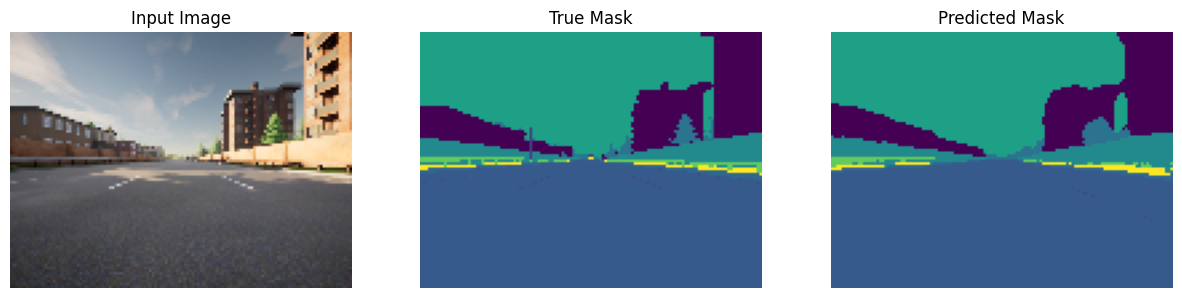

In [81]:
for image, mask in processed_image_ds.take(1):
    sample_image, sample_mask = image, mask
    #print(mask.shape)
    display([sample_image, sample_mask,
             create_mask(unet.predict(sample_image[tf.newaxis, ...]))])

In [82]:
predicted_mask = unet.predict(sample_image[tf.newaxis, ...])
predicted_mask.shape

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


(1, 96, 128, 23)

In [83]:
# take the channel index with the highest value
reduced_channeled_predicted_mask = tf.argmax(predicted_mask, axis=-1)
reduced_channeled_predicted_mask.shape # the first 1 represent the sample size

TensorShape([1, 96, 128])

In [84]:
# have the channel dimension back, instead of being 23 (num of classes) but be 1
# Now, segmentation_mask is a tensor where each pixel value indicates the predicted class
# (an integer in the range 0–22).
final_pred_mask = reduced_channeled_predicted_mask[..., tf.newaxis]
final_pred_mask.shape

TensorShape([1, 96, 128, 1])

In [85]:
# Convert the TensorFlow tensor to a NumPy array and remove the channel dimension
seg_mask_np = final_pred_mask.numpy().squeeze()
seg_mask_np.shape

(96, 128)

In [88]:
target_class = 8
binary_mask = (seg_mask_np == target_class).astype(np.uint8) * 255
print(binary_mask.shape)
print(binary_mask)

(96, 128)
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


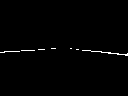

In [89]:
import numpy as np
from PIL import Image
Image.fromarray(binary_mask)

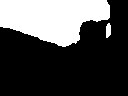

In [104]:
import numpy as np
from PIL import Image

def get_binary_mask(segmentation_mask, target_class):
    """
    Convert a multi-class segmentation mask to a binary mask for a specific target class.
    Pixels with the target_class are set to 255 (white) and all others to 0 (black).
    """
    # Convert the TensorFlow tensor to a NumPy array and remove the channel dimension
    seg_mask_np = segmentation_mask.numpy().squeeze()  # Shape becomes (H, W)
    # Create binary mask: True where the pixel equals target_class, then convert to 255/0
    binary_mask = (seg_mask_np == target_class).astype(np.uint8) * 255
    # Convert the NumPy array to a PIL image (the inpainting pipeline expects a PIL image)
    return Image.fromarray(binary_mask)

# Create the binary mask for the target class (e.g., class 13) 13 represents the sky
binary_mask = get_binary_mask(final_pred_mask, target_class = 13)
binary_mask

In [91]:
# Debug: Check the unique values in the segmentation mask
seg_mask_np = final_pred_mask.numpy().squeeze()  # Convert to NumPy and remove extra dimensions
print("Unique values in segmentation mask:", np.unique(seg_mask_np))
a = np.unique(seg_mask_np)
a[3] == 8

Unique values in segmentation mask: [ 1  6  7  8  9 11 13 17 22]


True

In [92]:
sample_image.shape

TensorShape([96, 128, 3])

In [80]:
print("Min pixel value:", np.min(sample_image.numpy()))
print("Max pixel value:", np.max(sample_image.numpy()))

Min pixel value: 0.00029219533
Max pixel value: 0.003921569


In [95]:
def get_pil_image_normalized(image_tensor):
    """
    Convert an image tensor to a PIL image by normalizing its pixel values to the full [0,255] range.
    """
    image_np = image_tensor.numpy()
    # Perform min-max normalization to scale pixel values to [0, 1]
    normalized = (image_np - np.min(image_np)) / (np.max(image_np) - np.min(image_np))
    # Scale normalized image to [0,255] and convert to uint8
    image_8bit = (normalized * 255).astype(np.uint8)
    return Image.fromarray(image_8bit)

# Use the normalized function to get a PIL image
pil_image = get_pil_image_normalized(sample_image)
pil_image  # This should display the image with a stretched contrast.

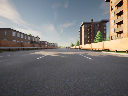

In [105]:
pil_image

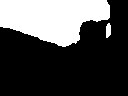

In [108]:
# class 13 (sky) is seleted, so it's white (pixel value 255), and the rest of the objects are black (pixel value 0)
binary_mask

In [98]:
!pip install diffusers transformers accelerate --upgrade

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 73.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 65.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 43.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 31.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 814.8 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 93.3 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu1

In [100]:
import torch
from diffusers import StableDiffusionInpaintPipeline

# Load the inpainting pipeline. Use fp16 for faster inference if a GPU is available.
pipe = StableDiffusionInpaintPipeline.from_pretrained(
    "runwayml/stable-diffusion-inpainting",
    torch_dtype=torch.float16
)

# Move the pipeline to the GPU if available; otherwise, it will run on the CPU.
device = "cuda" if torch.cuda.is_available() else "cpu"
pipe = pipe.to(device)

model_index.json:   0%|          | 0.00/548 [00:00<?, ?B/s]

Fetching 16 files:   0%|          | 0/16 [00:00<?, ?it/s]

safety_checker/config.json:   0%|          | 0.00/4.78k [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/617 [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

(…)ature_extractor/preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/748 [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/313 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/492M [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/552 [00:00<?, ?B/s]

diffusion_pytorch_model.bin:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

diffusion_pytorch_model.bin:   0%|          | 0.00/335M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

An error occurred while trying to fetch /root/.cache/huggingface/hub/models--runwayml--stable-diffusion-inpainting/snapshots/8a4288a76071f7280aedbdb3253bdb9e9d5d84bb/unet: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--runwayml--stable-diffusion-inpainting/snapshots/8a4288a76071f7280aedbdb3253bdb9e9d5d84bb/unet.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
An error occurred while trying to fetch /root/.cache/huggingface/hub/models--runwayml--stable-diffusion-inpainting/snapshots/8a4288a76071f7280aedbdb3253bdb9e9d5d84bb/vae: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--runwayml--stable-diffusion-inpainting/snapshots/8a4288a76071f7280aedbdb3253bdb9e9d5d84bb/vae.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.


  0%|          | 0/50 [00:00<?, ?it/s]

(96, 128, 3)


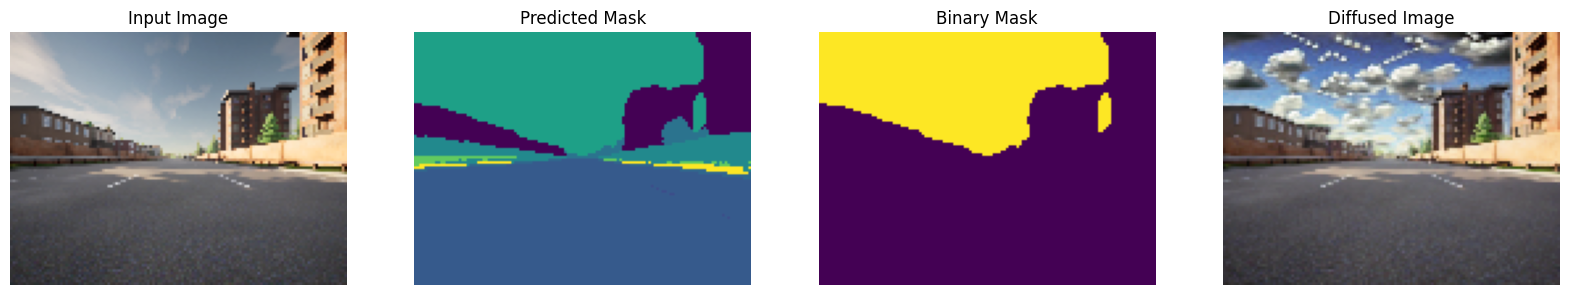

In [133]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from PIL import Image

def convert_to_pil_image(img):
    """
    Convert an image (tensor, numpy array, or PIL image) to a PIL image.
    If the image is grayscale (rank 2), add a channel dimension.
    """
    # If the image is already a PIL image, return it directly.
    if isinstance(img, Image.Image):
        return img
    # If the image is a TensorFlow tensor, convert it to a NumPy array.
    if isinstance(img, tf.Tensor):
        img = img.numpy()
    # If the image is grayscale (i.e., has shape (H, W)), expand dims to (H, W, 1)
    if img.ndim == 2:
        img = np.expand_dims(img, axis=-1)
    return tf.keras.preprocessing.image.array_to_img(img)

def display_replacement(display_list):
    plt.figure(figsize=(20, 5))
    titles = ['Input Image', 'Predicted Mask', 'Binary Mask', 'Diffused Image']

    for i, image in enumerate(display_list):
        # If image is a TensorFlow tensor and has a batch dimension, squeeze it.
        if isinstance(image, tf.Tensor) and image.ndim == 4:
            image = tf.squeeze(image, axis=0)
        # Convert the image to a PIL image (if it isn't already)
        pil_img = convert_to_pil_image(image)

        plt.subplot(1, len(display_list), i+1)
        plt.title(titles[i])
        plt.imshow(pil_img)
        plt.axis('off')
    plt.show()

# Define your text prompt
prompt = "decorated sky"
# Run the inpainting process
result = pipe(prompt=prompt, image=pil_image, mask_image=binary_mask).images[0]
# Convert the PIL image 'result' to a TensorFlow tensor
result_tensor = tf.keras.preprocessing.image.img_to_array(result)
# Resize using TensorFlow (note: the size argument is in (height, width))
result_tensor_resized = tf.image.resize(result_tensor, [96, 128])
print(result_tensor_resized.shape)
# Convert tensorflow tensor back to a PIL image
result_resized_tf = tf.keras.preprocessing.image.array_to_img(result_tensor_resized)
# Now call the function with your four images:
# pil_image: your original input image (tensor or PIL image)
# final_pred_mask: your predicted segmentation mask (tensor or NumPy array, shape (H, W, C))
# binary_mask: your binary mask for the selected object (already a PIL image)
# result: your diffused (inpainted) image (tensor, NumPy array, or PIL image)
display_replacement([pil_image, final_pred_mask, binary_mask, result_resized_tf])